# Creación de features

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


In [28]:
# Extraemos la data preprocesada

# Defino los paths de los archivos Excel
pipomessage_path = "Preprocesado/pipomessage.xlsx"
user_path = "Preprocesado/user.xlsx"
usermessage_path = "Preprocesado/usermessage.xlsx"
symptoms_path = "Preprocesado/symptoms.xlsx"

# Cargar los datos en pandas DataFrames
pipomessage_df = pd.read_excel(pipomessage_path)
user_df = pd.read_excel(user_path)
usermessage_df = pd.read_excel(usermessage_path)
symptoms_df = pd.read_excel(symptoms_path)

### Qué queremos predecir?
Determinar el tipo de cancer de los pacientes que por ahora estan completados como 'Desconocido' a partir de los sintomas e intensidades registradas por los pacientes. Solo trabajaremos con los 10 principales tipos de cancer y los 10 principales sintomas.

1. Excluir los casos de cáncer 'Desconocido' de los datos de entrenamiento y guardarlos para las predicciones.
2. Fusionar los dataframes 'user_df' y 'symptoms_df' en uno de modo que tengamos la información del usuario y los síntomas en un solo lugar.

In [39]:
train_user_df = user_df[user_df['cancer_type'] != 'desconocido']
predict_user_df = user_df[user_df['cancer_type'] == 'desconocido']

merged_df = pd.merge(train_user_df, symptoms_df, left_on='phone_number', right_on='user')

merged_df.head()

,phone_number,creation_date_x,cancer_type,id,user,creation_date_y,description,intensity
0,883434410131,2023-01-31 13:21:22.722753+00:00,cancer de mama,3657,883434410131,2023-02-01 13:55:26.490979+00:00,dolor corporal,6
1,883434410131,2023-01-31 13:21:22.722753+00:00,cancer de mama,3832,883434410131,2023-02-06 19:46:54.420442+00:00,dolor de vientre,6
2,883434410131,2023-01-31 13:21:22.722753+00:00,cancer de mama,3913,883434410131,2023-02-08 18:32:38.076702+00:00,sangrado,6
3,883811578438,2023-04-12 23:46:23.650111+00:00,cancer de mama,7157,883811578438,2023-04-18 17:10:31.079410+00:00,dolor de seno,6
4,9742951077857,2023-02-18 16:21:09.167504+00:00,cancer de ovario,4553,9742951077857,2023-02-24 15:18:12.711123+00:00,dolor corporal,6


In [40]:
# Eliminaremos las columnas que no considero relevantes
merged_df = merged_df.drop(columns=['creation_date_x', 'id', 'creation_date_y', 'user'])

# Top 10: tipos de cancer y sintomas
top_cancers = merged_df['cancer_type'].value_counts().index[:10]
top_symptoms = merged_df['description'].value_counts().index[:10]

# Filtramos
merged_df = merged_df[merged_df['cancer_type'].isin(top_cancers) & merged_df['description'].isin(top_symptoms)]

merged_df


,phone_number,cancer_type,description,intensity
0,883434410131,cancer de mama,dolor corporal,6
4,9742951077857,cancer de ovario,dolor corporal,6
5,9742951077857,cancer de ovario,cansancio,6
6,9742951077857,cancer de ovario,cansancio,6
7,9742951077857,cancer de ovario,nauseas,6
...,...,...,...,...
5769,93349831052308,ca cervix,no identificado,6
5770,93349831052308,ca cervix,dolor de estomago,6
5771,93349831052308,ca cervix,dolor de cabeza,6
5772,93349831052308,ca cervix,dolor de estomago,6


3. Utilizaremos 'label encoding' para codicar el tipo de cancer y sintoma

In [42]:
symptom_encoder = LabelEncoder()
cancer_encoder = LabelEncoder()

# Encoding
merged_df['symptom_encoded'] = symptom_encoder.fit_transform(merged_df['description'])
merged_df['cancer_encoded'] = cancer_encoder.fit_transform(merged_df['cancer_type'])

In [73]:
merged_df

,phone_number,cancer_type,description,intensity,symptom_encoded,cancer_encoded
0,883434410131,cancer de mama,dolor corporal,6,2,4
4,9742951077857,cancer de ovario,dolor corporal,6,2,5
5,9742951077857,cancer de ovario,cansancio,6,0,5
6,9742951077857,cancer de ovario,cansancio,6,0,5
7,9742951077857,cancer de ovario,nauseas,6,7,5
...,...,...,...,...,...,...
5769,93349831052308,ca cervix,no identificado,6,8,0
5770,93349831052308,ca cervix,dolor de estomago,6,5,0
5771,93349831052308,ca cervix,dolor de cabeza,6,3,0
5772,93349831052308,ca cervix,dolor de estomago,6,5,0


# Modelado

### Random Forest
Para este problema de clasificacion multiclase, se utilizara el modelo Random Forest debido a que es un algoritmo de aprendizaje automático flexible y fácil de usar que produce buenos resultados incluso sin ajuste de hiperparámetros.

In [92]:
# Preparamos la data
X = merged_df[['symptom_encoded', 'intensity']]
y = merged_df['cancer_encoded']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenamos el modelo
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [93]:
# Predecimos
y_pred = rf.predict(X_test)

# Calculamos accuracy
accuracy = accuracy_score(y_test, y_pred)

# Mostramos la confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)

In [94]:
accuracy

0.7421686746987952

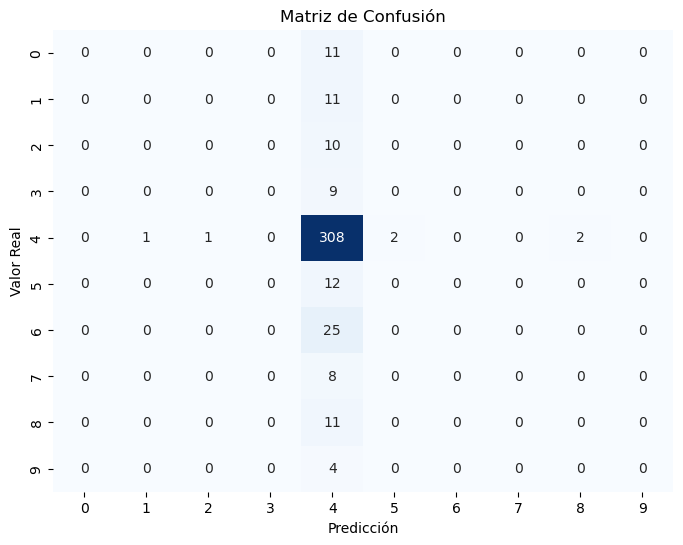

In [96]:
plt.figure(figsize=(8, 6))
ax = plt.subplot()

# Grafica matriz de confusión utilizando seaborn
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False)

# Etiquetas
ax.set_xlabel('Predicción')
ax.set_ylabel('Valor Real')
ax.set_title('Matriz de Confusión')

# Muestra la matriz de confusión
plt.show()

### Tunear hiperparametros

Tuneamos los hiperparametros de mi modelo de random forest classifier con RandomizedSearchCV y GridSearchCV. 

RandomizedSearchCV realiza una búsqueda aleatoria de hiperparámetros utilizando una combinación limitada de opciones, mientras que GridSearchCV realiza una búsqueda exhaustiva evaluando todas las combinaciones posibles.

In [105]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

rf_model = RandomForestClassifier()

random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid, n_iter=40, cv=5, scoring='accuracy')
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=40,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 5, 10],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   scoring='accuracy')

In [107]:
print("Mejores hiperparámetros encontrados:")
print(random_search.best_params_)
print("Mejor puntuación de cross validation:")
print(random_search.best_score_)

Mejores hiperparámetros encontrados:
{'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 5, 'bootstrap': True}
Mejor puntuación de cross validation:
0.7681159684053435


In [108]:
param_grid = {
    'n_estimators': [250, 280, 300],
    'max_depth': [4, 5, 6],
    'min_samples_split': [4, 5, 6],
    'min_samples_leaf': [3, 4, 5],
    'max_features': ['log2'],
    'bootstrap': [True]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [4, 5, 6],
                         'max_features': ['log2'],
                         'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [4, 5, 6],
                         'n_estimators': [250, 280, 300]},
             scoring='accuracy')

In [109]:
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)
print("Mejor puntuación de validación cruzada:")
print(grid_search.best_score_)

Mejores hiperparámetros encontrados:
{'bootstrap': True, 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 250}
Mejor puntuación de validación cruzada:
0.7681159684053435
